[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma2 on Object Detection Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![arXiv](https://img.shields.io/badge/arXiv-2412.03555-b31b1b.svg)](https://arxiv.org/abs/2412.03555)

PaliGemma 2 is built by combining the SigLIP-So400m vision encoder with the more recent and capable language models from the Gemma 2 family.

![PaliGemma2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-1.png)

The authors use a 3-stage training approach similar to the original PaliGemma. In stage 1, they combine the pretrained vision and language model components and train them jointly on a multimodal task mixture. In stage 2, they train the models at higher resolutions of 448px^2 and 896px^2. In stage 3, they fine-tune the models on the target transfer tasks.

PaliGemma 2 models outperform the original PaliGemma at the same resolution and model size. Increasing the model size and resolution generally improves performance across a wide range of tasks, but the benefits differ depending on the task. Some tasks benefit more from increased resolution, while others benefit more from a larger language model.

![PaliGemma2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-2.png)

Notebook requires A100 with 40GB of VRAM to train.

## Setup

### Configure your API keys

To fine-tune PaliGemma2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Mar 26 08:27:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:27:00.0 Off |                  N/A |
| 30%   34C    P8             24W /  350W |       2MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [2]:
#!pip install -q peft bitsandbytes transformers==4.47.0 tf-keras
import os
# if /tmp/indoorCVPR and /tmp/clevr-act-7-depth do not exist, transfer them from the shared folder
if not os.path.exists('/tmp/indoorCVPR') or not os.path.exists('/tmp/clevr-act-7-depth'):
    !rsync -a --progress /data/lmbraid19/argusm/datasets/indoorCVPR.tar /tmp/ && mkdir -p /tmp/indoorCVPR && tar -xf /tmp/indoorCVPR.tar -C /tmp/indoorCVPR
    !rsync -a --progress /data/lmbraid19/argusm/datasets/clevr-act-7-depth /tmp/
    !file /tmp/indoorCVPR
    !file /tmp/clevr-act-7-depth
else:
    print('Data already exists')

Data already exists


**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

In [4]:
%load_ext autoreload
%autoreload 2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision import transforms
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

from data_loader_h5 import H5Dataset, PairedH5Dataset
from data_loader_jsonl import JSONLDataset
from data_augmentations import augment_image_rgb, RandomizeBackgrounds
from data_augmentations import complexify_text, DepthAugmentation
from data_loader_images import ImageFolderDataset
from utils_vis import render_example

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
model_location = Path("/data/lmbraid21/bratulic/max_pali/models")
dataset_location = Path("/tmp/clevr-act-7-depth")

num_images_in_context = 1
image_order = "interleaved"
run_name = f"_imagesInContext_{num_images_in_context}_promptOrder_{image_order}"
load_presampled_pairs_path = Path("/data/lmbraid21/bratulic/max_pali/datasets") / f"train_dataset_{run_name}.pkl"
bg_image_dataset = ImageFolderDataset("/tmp/indoorCVPR/Images", transform=transforms.RandomResizedCrop((448,448)))
randomize_background = RandomizeBackgrounds(p=0.2, background_images=bg_image_dataset)
augment_depth = DepthAugmentation(depth_range=(25, 100), max_delta_depth=35)
raw_dataset = H5Dataset(dataset_location, augment_rgbds=randomize_background, augment_rgb=augment_image_rgb, augment_text=complexify_text,
                          augment_depth=augment_depth, return_depth=False)

train_dataset = PairedH5Dataset(raw_dataset, num_images_in_context=num_images_in_context, image_order=image_order, load_presampled_pairs_path=load_presampled_pairs_path)

print("dataset_location:", dataset_location,"samples:", len(raw_dataset), "paired_samples:", len(train_dataset))


/home/bratulic/miniforge3/envs/paligemma/lib/python3.12/site-packages/sapien/_vulkan_tricks.py:21: UserWarning: Failed to find system libvulkan. Fallback to SAPIEN builtin libvulkan.
  warn("Failed to find system libvulkan. Fallback to SAPIEN builtin libvulkan.")


Statistics about the paired dataset:
Number of tasks with more than one image: 15536
Tasks and number of images: [('put the large green block in the small brown block', 68), ('place the large gray ball inside the small green block', 8), ('put the small brown block inside the small blue ball', 14), ('place the small yellow block inside the small green sphere', 8), ('pick up the small cyan block and put it in the large red cube', 2), ('place the small blue ball inside the large yellow sphere', 4), ('put the large purple sphere in the small yellow block', 31), ('place the small blue block inside the large gray sphere', 8), ('put the large blue block in the small cyan ball', 43), ('put the large red ball in the small brown block', 35), ('put the large brown block in the small cyan block', 70), ('put the small purple cube in the small red ball', 12), ('put the large green ball in the large yellow cube', 11), ('put the large green sphere inside the large red sphere', 9), ('put the small gray

In [5]:
# store train_dataset lookup in a pickle file and load it later for faster loading
import pickle
store_path = Path("/data/lmbraid21/bratulic/max_pali/datasets")
store_path.mkdir(exist_ok=True)
store_file = store_path / f"train_dataset_{run_name}.pkl"
# train_dataset.task_lookup is a dictionary with string as key and list of indices as value
# store it properly so it can be easily loaded later as dictionary
if not store_file.exists():
    with open(store_file, "wb") as f:
        pickle.dump(train_dataset.task_lookup, f)

### Set up and test data loaders


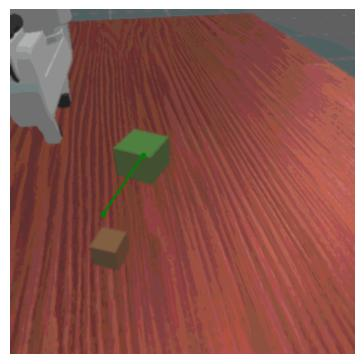
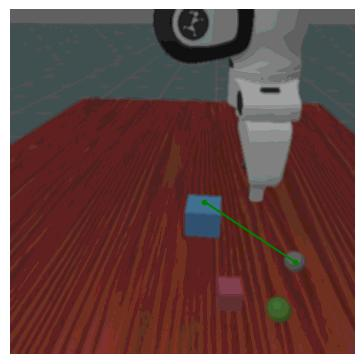
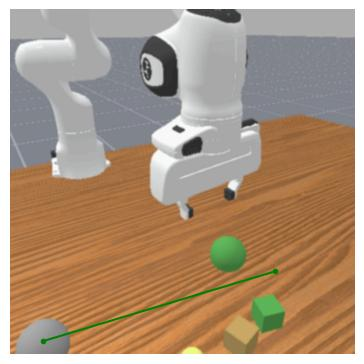
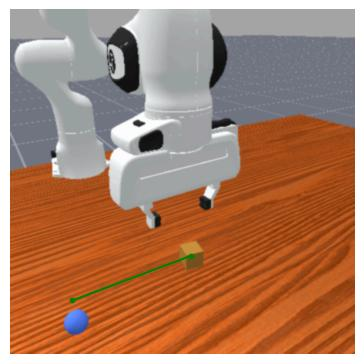
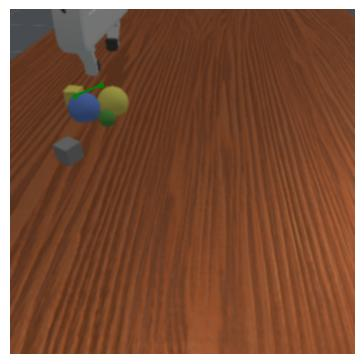
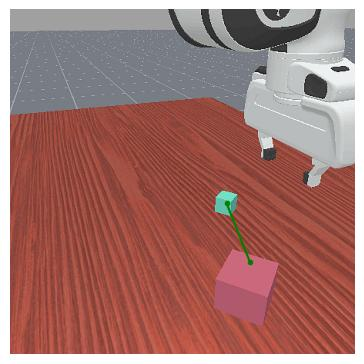

In [7]:
num_samples = 3*2
html_imgs = ""
for i in range(num_samples):
    image, sample = raw_dataset[i]
    prefix = sample["prefix"]
    html_imgs += render_example(image, label=sample["suffix"], text=prefix, camera=sample["camera"])

plot_images = True
if plot_images:
    from IPython.display import display, HTML
    display(HTML(html_imgs))
    

### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-448) checkpoint. Resolution has a key impact on the mAP of the trained model, and it seems that `448` offers the most optimal balance between performance and compute resources required to train the model.

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

In [8]:
# setting device on GPU if available, else CPU
print("cuda visible devices:", os.environ["CUDA_VISIBLE_DEVICES"])
devices_good = sorted((int(x) for x in os.environ["CUDA_VISIBLE_DEVICES"].split(",")))
DEVICE = torch.device('cuda')
print(DEVICE)
print('Using device:', DEVICE)
print("Good devices", devices_good)

TORCH_DTYPE = torch.bfloat16
SEQLEN = 12
MODEL_ID = "google/paligemma2-3b-pt-224"
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)
model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=TORCH_DTYPE, device_map="auto", attn_implementation='eager')

cuda visible devices: 0,1
cuda
Using device: cuda
Good devices [0, 1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
def augment_suffix(suffix):
    parts = suffix.split(' ; ')
    random.shuffle(parts)
    return ' ; '.join(parts)

if len(devices_good) == 1:
    def collate_fn(batch):
        images, labels = zip(*batch)        # images will be lists of lists since one batch input has multiple images
        prefixes, suffixes = [], []
        for i in range(len(labels)):
            tmp_prefix = ""
            if image_order == "interleaved":
                for j in range(num_images_in_context):
                    tmp_prefix += "<image>" + labels[i][j]["suffix"]
                tmp_prefix += "<image>"
            else:
                tmp_prefix = "<image>"*(num_images_in_context + 1)
                for j in range(num_images_in_context):
                    tmp_prefix += labels[i][j]["suffix"]
            prefixes.append(tmp_prefix)
            suffixes.append(labels[i][-1]["suffix"])
        
        images_flat = [image for images_list in images for image in images_list]

        inputs = processor(
            text=prefixes,
            images=images_flat,
            return_tensors="pt",
            suffix=suffixes,
            padding="longest"
        ).to(TORCH_DTYPE).to(DEVICE)

        return inputs
else:
    def collate_fn(batch):
        images, labels = zip(*batch)        # images will be lists of lists since one batch input has multiple images
        prefixes, suffixes = [], []
        for i in range(len(labels)):
            tmp_prefix = ""
            if image_order == "interleaved":
                for j in range(num_images_in_context):
                    tmp_prefix += "<image>" + labels[i][j]["suffix"]
                tmp_prefix += "<image>"
            else:
                tmp_prefix = "<image>"*(num_images_in_context + 1)
                for j in range(num_images_in_context):
                    tmp_prefix += labels[i][j]["suffix"]
            prefixes.append(tmp_prefix)
            suffixes.append(labels[i][-1]["suffix"])
        
        images_flat = [image for images_list in images for image in images_list]

        inputs = processor(
            text=prefixes,
            images=images_flat,
            return_tensors="pt",
            suffix=suffixes,
            padding="longest"
        ).to(TORCH_DTYPE)

        return inputs
    

In [8]:
def compute_metrics(eval_pred):
    predictions, label_tokens = eval_pred  # Extract predictions and labels
    if isinstance(predictions, tuple):  # Some models return tuples
        predictions = predictions[0]

    # Convert to token indices if necessary (e.g., for text generation models)
    pred_tokens = np.argmax(predictions, axis=-1)  # Assuming logits, take argmax

    pred_texts = processor.tokenizer.batch_decode(pred_tokens[:,-SEQLEN-1:], skip_special_tokens=True)
    label_text = processor.tokenizer.batch_decode(label_tokens[:,-SEQLEN-1:], skip_special_tokens=True)

    print(pred_tokens[:,-SEQLEN-1:])
    print(label_tokens[:,-SEQLEN-1:])
    print(label_text)
    print(pred_texts)
    print()
    return {"accuracy": 0}

## Fine-tune with JAX settings

In [10]:
for param in model.vision_tower.parameters():
    param.requires_grad = False

for param in model.multi_modal_projector.parameters():
    param.requires_grad = False
    
for name, param in model.named_parameters():
    if param.requires_grad == True:
        if "self_attn" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

TRAIN_EXAMPLES = len(train_dataset)
BATCH_SIZE = 32
BATCH_SIZE_DEV = 2 # on l40 was 8
GRAD_ACCUM = int(round(BATCH_SIZE / BATCH_SIZE_DEV))
TRAIN_STEPS = (TRAIN_EXAMPLES // BATCH_SIZE)
SEQLEN = 12
SAVE_STEPS = int(TRAIN_STEPS / 15)
SAVE_LIMIT = 5

run_name = "_depthaug"
save_path = model_location / (str(Path(dataset_location).stem) + run_name)
print("save_path", save_path)
print("TRAIN_STEPS",TRAIN_STEPS)
print("GRAD_ACCUM", GRAD_ACCUM)

args_jax = Seq2SeqTrainingArguments(
    max_steps=TRAIN_STEPS,
    remove_unused_columns=False,
    per_device_train_batch_size=BATCH_SIZE_DEV,
    gradient_accumulation_steps=GRAD_ACCUM,
    learning_rate=3e-5,  # 1e-5, 2e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=.05,
    generation_max_length=SEQLEN,
    logging_steps=10,
    optim="adafactor",
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    save_total_limit=SAVE_LIMIT,
    output_dir=save_path,
    bf16=True,
    report_to=["tensorboard"],
    dataloader_pin_memory=False,
    dataloader_num_workers=4,
    #dataloader_prefetch_factor=2,
    #eval_strategy="steps",
    #eval_steps=4,
    #per_device_eval_batch_size=BATCH_SIZE_DEV,
    #eval_accumulation_steps=GRAD_ACCUM
)
#gradient_checkpointing=True,
#weight_decay=3e-7,

trainer = Seq2SeqTrainer(
    model=model,
    train_dataset=train_dataset,
    #eval_dataset=train_dataset_small,
    data_collator=collate_fn,
    args=args_jax,
    #compute_metrics=compute_metrics
)

save_path /data/lmbraid21/bratulic/max_pali/models/clevr-act-7-depth_depthaug
TRAIN_STEPS 4687
GRAD_ACCUM 16


In [11]:
trainer.train()

Step,Training Loss
10,14.609300
20,13.983400
30,11.466000
40,8.298500
50,6.240000
60,4.961800
70,4.346300
80,3.990800
90,3.840500
100,3.836500
